# Assignment 1 Lukas Schreiner Due: 18.Okt


In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

### Exercise 1.1 & 1.2

In [2]:
#Load Data
SP500 = pd.read_csv("SP500daily.csv",
                sep         = ",",
                dtype       = {"Date"       : str, 
                               "Open"       : np.float32, 
                               "High"       : np.float32,
                               "Low"        : np.float32,
                               "Close"      : np.float32,
                               "Adj Close"  : np.float32,
                               "Volume"     : np.int32,},
                decimal     = ".",
                engine      = "python")

In [3]:
#Adjust Date format
SP500['Date']  = pd.to_datetime(SP500['Date'])
SP500['Week']  = SP500['Date'].dt.week
SP500['Month'] = SP500['Date'].dt.month
SP500['Year']  = SP500['Date'].dt.year

#Calculate Returns and Log returns
SP500['Return'] = SP500.Close.pct_change()
SP500['Log Return'] = np.log(SP500.Close) - np.log(SP500.Close.shift(1))

#Rearrage Columns
cols = ['Date', 'Week', 'Month', 'Year', 
        'Open', 'High', 'Low', 'Close', 
        'Adj Close', 'Volume',  'Return', 
        'Log Return']

SP500 = SP500[cols].set_index('Date')

SP500.head()

,Week,Month,Year,Open,High,Low,Close,Adj Close,Volume,Return,Log Return
Date,,,,,,,,,,,
1950-01-03,1,1,1950,16.66,16.66,16.66,16.66,16.66,1260000,NaN,NaN
1950-01-04,1,1,1950,16.85,16.85,16.85,16.85,16.85,1890000,0.011405,0.011340
1950-01-05,1,1,1950,16.93,16.93,16.93,16.93,16.93,2550000,0.004748,0.004737
1950-01-06,1,1,1950,16.98,16.98,16.98,16.98,16.98,2010000,0.002953,0.002949
1950-01-09,2,1,1950,17.08,17.08,17.08,17.08,17.08,2520000,0.005889,0.005872


In [4]:
def calculate_return_over_period(time_window, time_horizon = ['1950-01-03','2017-12-27']): 
    
    value_endofperiod = []
    log_returns_period = []
    period = 0

    for index, row in SP500[time_horizon[0]:time_horizon[1]].iterrows():
        if row[time_window] != period:    
            value_endofperiod.append(row['Close']) 
            period = row[time_window]

    #The closing value of a period is the opening value of the next period
    for i in range(1,len(value_endofperiod)):
        log_returns_period.append(np.log(value_endofperiod[i] / value_endofperiod[i-1]))
    
    return log_returns_period

In [5]:
log_mean_daily = np.mean(SP500['Log Return'])

log_returns_weekly  = calculate_return_over_period('Week')

log_returns_monthly = calculate_return_over_period('Month')

log_returns_yearly  = calculate_return_over_period('Year')

In [6]:
output = {'Daily':   [(np.mean(SP500['Log Return'])*100),   (np.var(SP500['Log Return'])*100)], 
          'Weekly':  [(np.mean(log_returns_weekly)*100), (np.var(log_returns_weekly)*100)], 
          'Monthly': [(np.mean(log_returns_monthly)*100),(np.var(log_returns_monthly)*100)], 
          'Yearly':  [(np.mean(log_returns_yearly)*100), (np.var(log_returns_yearly)*100)]} 

ouput_table = pd.DataFrame(data = output, index = ['Mean', 'Variance'])
ouput_table

,Daily,Weekly,Monthly,Yearly
Mean,0.029713,0.143241,0.621640,7.327088
Variance,0.009303,0.051615,0.173604,2.470160


### Exercise 1.3

In [7]:
#Initial Investment = 1
init_inv = 1

value_inv_today = init_inv * (SP500['Return'] + 1).cumprod().iloc[-1]
print("Value of 1 USD Investment today: %.2f USD" % round(value_inv_today,2)) 

Value of 1 USD Investment today: 161.32 USD


### Exercise 1.4

In [8]:
#Import Data
TBill = pd.read_csv("DTB3.csv",
                sep         = ",",
                dtype       = {"DATE" : str, 
                               "DTB3" : str,
                              },
                decimal     = ".",
                engine      = "python")

# Correct for annulization
TBill['Log TB3'] = np.log(pd.to_numeric(TBill['DTB3'], errors = 'coerce')/100 + 1) /365
TBill['DATE'] = pd.to_datetime(TBill['DATE'])

#Handle NAN values through interpolation
TBill['Log TB3'] = TBill['Log TB3'].interpolate()
print("Number of NAN Values in TB3: ", TBill['Log TB3'].isna().sum())

#Merge Datasets
SP500 = SP500.join(TBill.set_index("DATE"))
SP500[["Close", "Log Return" ,"Log TB3"]].tail(5)

#writer = pd.ExcelWriter('output.xlsx')
#df.to_excel(writer,'Sheet1')
#writer.save()

Number of NAN Values in TB3:  0


,Close,Log Return,Log TB3
Date,,,
2017-12-21,2684.570068,0.001984,0.000036
2017-12-22,2683.340088,-0.000459,0.000036
2017-12-26,2680.500000,-0.001059,0.000039
2017-12-27,2682.620117,0.000791,0.000039
2017-12-28,2687.540039,0.001832,0.000037


In [9]:
risk_free = np.mean(SP500["Log TB3"]['2000-01-03':'2017-12-27'])

cum_log_returns     = (SP500['Log Return']['2000-01-03':'2017-12-27'] + 1).cumprod().iloc[-1]
cum_log_rf_returns  = (SP500['Log TB3']['2000-01-03':'2017-12-27'] + 1).cumprod().iloc[-1]

cum_excess_return = cum_log_returns - cum_log_rf_returns

print("The excess return over the period is %.4f percent" % (cum_excess_return*100))

The excess return over the period is 9.3603 percent


### Exercise 1.5

In [10]:
def sharpe_ratio(return_data, risk_free):
    
    excess_return  = [r - risk_free for r in return_data]
    
    avg_excess_ret = np.sum(excess_return) / len(excess_return)
    
    sharpe_ratio   = avg_excess_ret / np.var(excess_return)
    
    return sharpe_ratio

log_ret_weekly2    = calculate_return_over_period("Week",['2000-01-03','2017-12-27'])

log_ret_monthly2   = calculate_return_over_period("Month",['2000-01-03','2017-12-27'])

log_ret_yearly2    = calculate_return_over_period("Year",['2000-01-03','2017-12-27'])

In [11]:
shr_daily     = sharpe_ratio(SP500["Log Return"]['2000-01-03':'2017-12-27'], risk_free)

shr_weekly    = sharpe_ratio(log_ret_weekly2, risk_free)

shr_monthly   = sharpe_ratio(log_ret_monthly2, risk_free)

shr_yearly    = sharpe_ratio(log_ret_yearly2, risk_free)

sharpe = pd.DataFrame({'Daily'   : [shr_daily],
                       'Weekly'  : [shr_weekly], 
                       'Monthly' : [shr_monthly],
                       'Yearly'  : [shr_yearly]}, 
                       index = ['Sharpe Ratio'])

ouput_table = ouput_table.append(sharpe, sort = True)
ouput_table

,Daily,Monthly,Weekly,Yearly
Mean,0.029713,0.621640,0.143241,7.327088
Variance,0.009303,0.173604,0.051615,2.470160
Sharpe Ratio,0.612561,1.242548,0.938394,0.921107


### Exercise 2.1

In [12]:
#Import Data
stock_data = pd.read_excel('PS1-2_Studynet.xlsx')

#Clean Header
stock_data.columns = stock_data.columns.str.replace("Equity", "")
stock_data.columns = stock_data.columns.str.replace("SE", "")
stock_data.columns = stock_data.columns.str.replace("SW", "")
stock_data.columns = stock_data.columns.str.replace(" ", "")

In [13]:
stock_cols = stock_data.columns
stock_data = stock_data.set_index('Date')
stock_data.head()

,ABBN,SPSN,SIKA,LOGN,PGHN,DOKA,ZURN,AMS,GIVN,SOON,...,LONN,CLN,NESN,ARYN,HELN,GEBN,FHZN,ROG,PSPN,UBSG
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19.94,56.57,26.92,17.93,130.6,249.10,226.5,4.53,826.5,125.5,...,67.62,12.146,50.20,38.074,320.75,183.5,62.25,175.8,58.50,16.05
2010-01-08,21.05,57.69,27.75,18.65,138.2,257.25,232.4,5.10,863.0,128.9,...,73.13,12.573,49.11,38.667,334.75,185.3,62.35,178.5,61.30,17.21
2010-01-15,20.61,59.00,27.37,18.65,132.0,257.25,233.0,5.23,868.5,132.1,...,75.86,12.513,49.12,39.407,331.00,191.2,60.70,184.4,61.90,16.10
2010-01-22,19.26,58.22,26.40,18.44,131.4,263.00,226.9,5.59,873.0,133.6,...,73.08,11.609,50.55,40.988,326.50,189.2,58.50,184.8,60.60,14.93
2010-01-29,19.45,58.22,27.18,18.13,132.0,266.25,227.6,5.60,869.5,131.9,...,70.07,11.688,50.50,41.580,331.75,187.7,60.00,178.5,60.95,14.03


Text(0.5,1,'Prices / LISN')

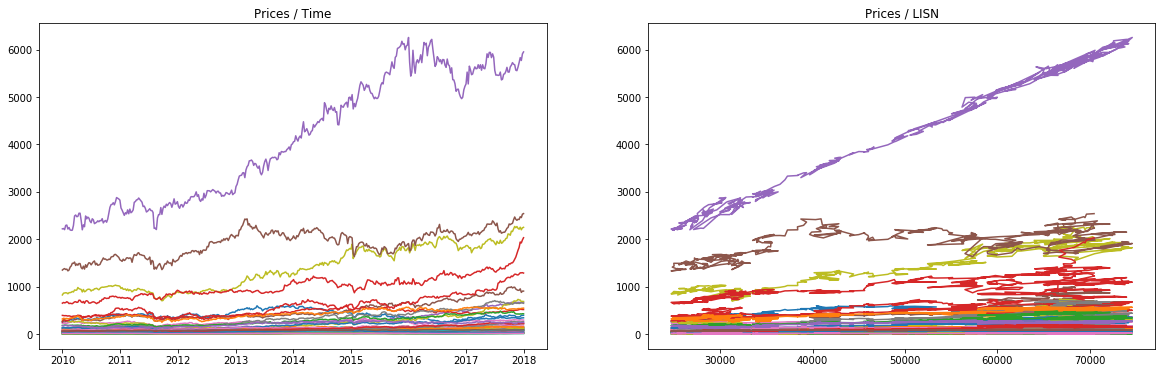

In [14]:
figure_1 = plt.figure(figsize=(20,6))
chart_1  = figure_1.add_subplot(121)
chart_2  = figure_1.add_subplot(122)

for i in range(1,len(stock_cols)):
    if stock_cols[i] != 'LISN':
        chart_1.plot(stock_data.index, stock_data[stock_cols[i]], label = stock_cols[i])

for i in range(1,len(stock_cols)):
    if stock_cols[i] != 'LISN':
        chart_2.plot(stock_data['LISN'], stock_data[stock_cols[i]], label = stock_cols[i])
        
chart_1.set_title('Prices / Time')
chart_2.set_title('Prices / LISN')

### Exercise 2.2

In [15]:
# The risk free rate
risk_free = np.log(0.27 + 1) / 100 

In [16]:
# log_returns calclates the log return of a given dataset and returns a dataframe with only its log returns

def log_returns(dataset):
    
    cols = dataset.columns
    
    for i in range(0,len(cols)):
        
        #Calculate Log returns
        dataset['LG_' + cols[i]] = np.log(dataset.loc[:,(cols[i])]) - np.log(dataset.loc[:,(cols[i])].shift(1))
        
        #Delete Stocks Prices
        dataset = dataset.drop(cols[i],1)
        
        #Delete first row (contains 'NaN')
        lg_dataset = dataset.iloc[1:]
        
    return lg_dataset

In [17]:
#Selected Stocks
selected_stocks_cols = ['CSGN', 'UBSG', 'ABBN', 'NESN', 'NOVN', 'CFR']

selected_stocks = stock_data.loc[:,(selected_stocks_cols)]

lg_selected_stocks = log_returns(selected_stocks)
lg_selected_stocks.head()

,LG_CSGN,LG_UBSG,LG_ABBN,LG_NESN,LG_NOVN,LG_CFR
Date,,,,,,
2010-01-08,0.090500,0.069782,0.054173,-0.021952,-0.048967,0.048886
2010-01-15,-0.075005,-0.066671,-0.021124,0.000204,0.006485,0.000274
2010-01-22,-0.099807,-0.075447,-0.067746,0.028697,0.038048,-0.041988
2010-01-29,-0.010898,-0.062175,0.009817,-0.000990,0.010610,0.034283
2010-02-05,-0.054067,-0.010749,-0.034522,-0.043507,0.005263,-0.035713


In [18]:
#Expected Log Returns for selected stocks
sel_expret  = np.mean(lg_selected_stocks)
#print(expected_returns)

#Covariance matrix rounded to 6 decimals for selected stocks
sel_covmat = np.round(np.cov(lg_selected_stocks.values.T[:]),6)
print(sel_covmat)

[[0.002258 0.001609 0.000986 0.000302 0.000446 0.000943]
 [0.001609 0.001759 0.000874 0.000293 0.000385 0.0009  ]
 [0.000986 0.000874 0.001134 0.000312 0.000428 0.000851]
 [0.000302 0.000293 0.000312 0.000407 0.00029  0.000381]
 [0.000446 0.000385 0.000428 0.00029  0.000658 0.000409]
 [0.000943 0.0009   0.000851 0.000381 0.000409 0.001607]]


In [19]:
def portfolio_ret(w, expected_returns):
    return np.sum(expected_returns * w)*100

def portfolio_vol(w, cov_mat):
    return np.sqrt(np.dot(np.dot(w.T,cov_mat), w))

In [20]:
def min_variance(ret, expected_returns, cov_mat, rf_rate = 0):
    
    num_assets = len(expected_returns)
    
    args = (cov_mat)
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}, 
                   {'type': 'eq', 'fun': lambda w: portfolio_ret(w , expected_returns) + rf_rate - ret})
    
    result = minimize(portfolio_vol, num_assets*[1./num_assets,], args = args,
                        method = 'SLSQP', constraints = constraints)
    
    mu  = portfolio_ret(result.x, expected_returns)
    var = portfolio_vol(result.x, cov_mat)

    return mu, var, result.x

### Exercise 2.3

In [21]:
#This functions takes a vector of expeteced returns and a respective covariance matrix and returns 
# the effiecient frontier and a bunch of random (worse) portfolios

def calc_efficient_fontier(exp_ret, cov_mat):
        
    
    #Find optimal minimum Variance Porfolios (minvar)
    minvar_ret = []
    minvar_std = []
    minvar_wg  = []
    x = 0
    
    for i in range(0,40):
        
        #Calculate the mean (mu), standard deviations (var) and repective weights (w) of a desired portfolio return (x)
        #and store in lists
        mu, var, w = min_variance(x, exp_ret, cov_mat)

        minvar_ret.append(round(mu,6))
        minvar_std.append(np.sqrt(var))
        minvar_wg.append(w)

        x += 0.01


    #Random Portfolios (rp)
    rp_ret = []
    rp_std = []

    for i in range(0,1000):
        
        #Choose Random weights and calculate repective mean return (rp_ret) and standard deviations (rp_std)
        rn = np.random.normal(0,1,len(exp_ret))
        rp_w = rn / np.sum(rn)

        rp_ret.append(portfolio_ret(rp_w, exp_ret))
        rp_std.append(np.sqrt(portfolio_vol(rp_w, cov_mat)))

    return minvar_ret, minvar_std, minvar_wg, rp_ret, rp_std

In [22]:
#Calculate Efficient Frontier, and 1000 Random Portfolios and plot them (with selected assets)
sel_minvar_ret, sel_minvar_std, sel_minvar_wg, sel_rp_ret, sel_rp_std = calc_efficient_fontier(sel_expret, sel_covmat)


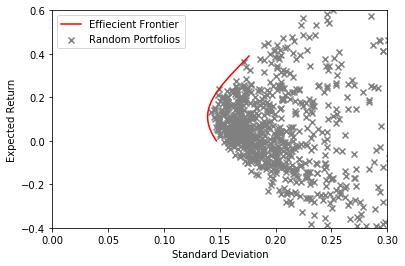

In [23]:
#Plot random portfolios and efficient frontier
plt.scatter(sel_rp_std, sel_rp_ret, marker = 'x', color = 'grey', label = 'Random Portfolios' )
plt.plot(sel_minvar_std, sel_minvar_ret, color = 'red', label = 'Effiecient Frontier')

plt.legend()

axes = plt.gca()
axes.set_xlim([0,0.3])
axes.set_ylim([-0.4,0.6])

plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")

plt.show()

In [24]:
def tangency_portfolio(minvar_std, minvar_ret):
    
    tangecy_std = []
    tangecy_ret = []
    
    for i in range(0,40):

        w = i/40
        
        tangecy_std.append(minvar_std[i] * w)
        tangecy_ret.append(minvar_ret[i] * w + (1 - w) * risk_free)
    
    return tangecy_std, tangecy_ret

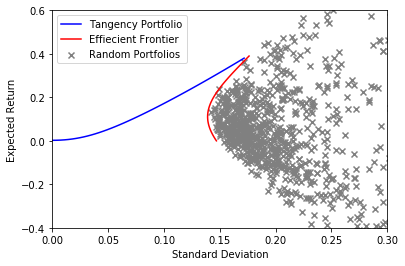

In [25]:
#Calculate and plot the tangency portfilio for selected assets
sel_tangecy_std, sel_tangecy_rett = tangency_portfolio(sel_minvar_std,sel_minvar_ret)

plt.plot(sel_tangecy_std, sel_tangecy_rett, color = 'blue',  label = 'Tangency Portfolio')
plt.scatter(sel_rp_std, sel_rp_ret, marker = 'x', color = 'grey', label = 'Random Portfolios' )
plt.plot(sel_minvar_std, sel_minvar_ret, color = 'red', label = 'Effiecient Frontier')
plt.legend()

axes = plt.gca()
axes.set_xlim([0,0.3])
axes.set_ylim([-0.4,0.6])

plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")

plt.show()

### Exercise 2.4

In [26]:
lg_stock_data = log_returns(stock_data)
lg_stock_data.head()

,LG_ABBN,LG_SPSN,LG_SIKA,LG_LOGN,LG_PGHN,LG_DOKA,LG_ZURN,LG_AMS,LG_GIVN,LG_SOON,...,LG_LONN,LG_CLN,LG_NESN,LG_ARYN,LG_HELN,LG_GEBN,LG_FHZN,LG_ROG,LG_PSPN,LG_UBSG
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-08,0.054173,0.019605,0.030366,0.039371,0.056563,0.032194,0.025715,0.118519,0.043215,0.026731,...,0.078335,0.034552,-0.021952,0.015455,0.042722,0.009761,0.001605,0.015242,0.046753,0.069782
2010-01-15,-0.021124,0.022454,-0.013788,0.000000,-0.045900,0.000000,0.002578,0.025171,0.006353,0.024522,...,0.036651,-0.004784,0.000204,0.018957,-0.011266,0.031344,-0.026820,0.032519,0.009740,-0.066671
2010-01-22,-0.067746,-0.013309,-0.036084,-0.011324,-0.004556,0.022106,-0.026529,0.066568,0.005168,0.011291,...,-0.037335,-0.074987,0.028697,0.039336,-0.013688,-0.010515,-0.036917,0.002167,-0.021225,-0.075447
2010-01-29,0.009817,0.000000,0.029117,-0.016954,0.004556,0.012282,0.003080,0.001787,-0.004017,-0.012806,...,-0.042060,0.006782,-0.000990,0.014340,0.015952,-0.007960,0.025318,-0.034686,0.005759,-0.062175
2010-02-05,-0.034522,-0.004994,-0.047467,-0.079170,-0.007605,-0.020874,0.041735,0.035091,-0.020919,-0.037857,...,0.003419,-0.043453,-0.043507,-0.028913,-0.029830,-0.019366,-0.005013,-0.049967,0.002458,-0.010749


In [27]:
#Expected Log Returns for 48 Stocks
all_expret = np.mean(lg_stock_data)
#print(expected_returns)

#Covariance matrix for 48 stocks rounded to 6 decimals
all_covmat = np.round(np.cov(lg_stock_data.values.T[:]),6)
#print(cov_mat)

In [28]:
#Calculate Efficient Frontier, and 1000 Random Portfolios and plot them (with all assets)
all_minvar_ret, all_minvar_std, all_minvar_wg, all_rp_ret, all_rp_std = calc_efficient_fontier(all_expret, all_covmat)


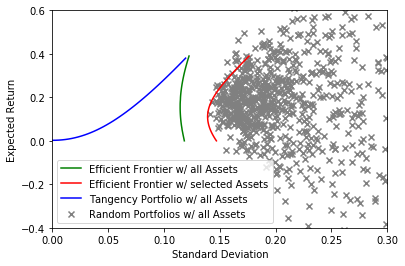

In [29]:
all_tangecy_std, all_tangecy_ret = tangency_portfolio(all_minvar_std, all_minvar_ret)

plt.scatter(all_rp_std, all_rp_ret, marker = 'x', color = 'grey',  label = 'Random Portfolios w/ all Assets' )
plt.plot(all_minvar_std, all_minvar_ret, color = 'green', label = 'Efficient Frontier w/ all Assets')
plt.plot(sel_minvar_std, sel_minvar_ret, color = 'red', label = 'Efficient Frontier w/ selected Assets')
plt.plot(all_tangecy_std, all_tangecy_ret, color = 'blue', label = 'Tangency Portfolio w/ all Assets')
plt.legend()

axes = plt.gca()
axes.set_xlim([0,0.3])
axes.set_ylim([-0.4,0.6])

plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")

plt.show()

In [30]:
"""
TO DO: 

    - Fix Tangency Porfolio (def tangency_portfolio(minvar_std, minvar_ret):)
    - Extract Weights of the riskless asset in tangency portfolio (Excersise 2.5)

"""

'\nTO DO: \n\n    - Fix Tangency Porfolio (def tangency_portfolio(minvar_std, minvar_ret):)\n    - Extract Weights of the riskless asset in tangency portfolio (Excersise 2.5)\n\n'